In [3]:
import os 
import glob
import xarray as xr
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import datetime

os.environ["PROJ_LIB"] = "C:/Users/Holdenje/Documents/R/win-library/3.5/sf/proj"
from mpl_toolkits.basemap import Basemap
%matplotlib inline

#plt.rcParams['figure.figsize'] = [12, 12]
#plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

#some pd parameters
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'left')

plt.rcParams['figure.figsize'] = [20, 20]
plt.rcParams['figure.dpi'] = 100 # e.g. 100 is adequate, 200 is better but slower

In [10]:
def read_aggregated_output(file):
    with xr.open_dataset(file) as ds:
        vars_to_keep = ['obs_lon','obs_lat','mod_lon','mod_lat','sep','time']
        df = ds[vars_to_keep].to_dataframe()

        dflist = []
        for m in ds.model_run.values:
            subdf = df[(df.index.get_level_values('model_run') == m)].copy()
            subdf = subdf.reset_index()
            dflist.append(subdf)
            #print(subdf.head())
            
        return dflist
    
def plot_single_aggregated_file(dflist, bbox=None, savedir=None, savename=None, pcolors=None, useid=None):    
    #convert the bbox string to a more useable format
    if bbox:
        # assumes bbox has order [lonmin latmin lonmax latmax]
        bboxvals = bbox.split(" ")
        lonmin, lonmax, latmin, latmax = float(bboxvals[0]), float(bboxvals[2]), float(bboxvals[1]), float(bboxvals[3])
        bbox_lats = [latmax, latmin, latmin, latmax, latmax]
        bbox_lons = [lonmax, lonmax, lonmin, lonmin, lonmax]
    
    #obslat = dflist[0].obs_lat.values.tolist()
    obslat = []
    obslon = []
    modlat = []
    modlon = []
    for df in dflist:
        obslat.extend(df.obs_lat.values.tolist())
        obslon.extend(df.obs_lon.values.tolist())
        modlat.extend(df.mod_lat.values.tolist())
        modlon.extend(df.mod_lon.values.tolist())
    
    all_lats = obslat + modlat
    all_lons = obslon + modlon
    
    if bbox:
        all_lats = all_lats + bbox_lats
        all_lons = all_lons + bbox_lons
    
    fig, ax = plt.subplots(1,1,figsize=(15,8))
    axisbuff = [-0.01, 0.01, -0.01, 0.01] #extra tight
    map = Basemap(
        projection='merc', 
        llcrnrlon=np.nanmin(all_lons)+axisbuff[0], 
        urcrnrlon=np.nanmax(all_lons)+axisbuff[1], 
        llcrnrlat=np.nanmin(all_lats)+axisbuff[2], 
        urcrnrlat=np.nanmax(all_lats)+axisbuff[3], 
        resolution='f', 
        ax=ax
        )

    map.drawcoastlines(linewidth=0.25)
    map.drawcountries(linewidth=0.25)
    #lightgray, whitesmoke, gray
    map.fillcontinents(color='whitesmoke',lake_color='white')
    map.drawmapboundary(fill_color='white')
    parallels = np.arange(-90,90,0.1)
    meridians = np.arange(0,360,0.1)
    map.drawparallels(parallels, labels=[False,True,True,False])
    map.drawmeridians(meridians, labels=[True,False,False,True], rotation=45)
    
    def drifter_plot(lats, lons, datatype, modrun, pcolors=None):
        x,y = map(lons, lats)
        if datatype == 'mod':
            stcolor = 'g'
            ocolor = 'r'
            zo = 1
            linest = ':'
            linew = 1
        elif datatype == 'obs':
            stcolor = 'r'
            ocolor = 'g'
            zo = 200
            linest = '-'
            linew = 1
        else:
            print('is there an error here?')
            stcolor = 'y'
            zo = 1
            linest = '-'  
        if pcolors:
            stcolor = pcolors[buoyid]
    
        plotcolors = {'0':'orange', '1':'green', '2':'blue', '3':'purple', '4':'yellow', '5':'magenta', '6':'black', 
                      '7':'red', '8':'gray', '9':'yellow', '10':'orange', '11':'purple', '12':'yellow', '13':'magenta', '14':'magenta'}
        plotlabel = datatype + ' ' + str(modrun)
        map.plot(x,y, linestyle=linest, color=plotcolors[str(modrun)], zorder=zo, linewidth=linew, label=plotlabel)
        #map.plot(x,y, linestyle=linest, color=stcolor, zorder=zo, linewidth=linew, label=plotlabel)
        #map.plot(x[0], y[0], color=ocolor, marker='.', zorder=300, markersize=6)
        map.plot(x[0], y[0], color=plotcolors[str(modrun)], marker='.', zorder=300, markersize=10)
    
    
    for df in dflist:
        modrun = np.unique(df.model_run.values.tolist())[0]
        obslat = df.obs_lat.values.tolist()
        obslon = df.obs_lon.values.tolist()
        modlat = df.mod_lat.values.tolist()
        modlon = df.mod_lon.values.tolist()
        drifter_plot(obslat, obslon, 'obs', modrun, pcolors)
        drifter_plot(modlat, modlon, 'mod', modrun, pcolors)
        
        print('')
        print('modelrun: ', modrun)
        print('obslat: ', np.nanmax(obslat), np.nanmin(obslat))
        print('obslon: ', np.nanmax(obslon), np.nanmin(obslon))
        
    #plot the bbox
    if bbox:
        cx, cy = map(bbox_lons, bbox_lats)
        map.plot(cx, cy, 'b--', zorder=1, linewidth=1)
        bbox_pairs = [(i, j) for i in bbox_lons for j in bbox_lats if i != j]
        for pair in bbox_pairs:
            x, y = map(pair[0], pair[1])
            map.plot(x, y, 'r.', zorder=zo, markersize=15)
    
    plt.legend(bbox_to_anchor=(1.05, 1))
    
    if savedir == 'None':
        savedir = "C:/Users/Holdenje/DRIFT/sample_drift-tool_output/mldp_implementation/plots/"
    
    if savename:
        plt.savefig(os.path.join(savedir, savename))
    plt.show()
    
def examine_data(dflist):    
    
    #obslat = dflist[0].obs_lat.values.tolist()
    obslat = []
    obslon = []
    modlat = []
    modlon = []
    for df in dflist:
        obslat.extend(df.obs_lat.values.tolist())
        obslon.extend(df.obs_lon.values.tolist())
        modlat.extend(df.mod_lat.values.tolist())
        modlon.extend(df.mod_lon.values.tolist())
    
    all_lats = obslat + modlat
    all_lons = obslon + modlon
    
    for df in dflist:
        modrun = np.unique(df.model_run.values.tolist())[0]
        obslat = df.obs_lat.values.tolist()
        obslon = df.obs_lon.values.tolist()
        modlat = df.mod_lat.values.tolist()
        modlon = df.mod_lon.values.tolist()
        
        print('')
        print('modelrun: ', modrun)
        print('obslat: ', np.nanmax(obslat), np.nanmin(obslat))
        print('modlat: ', np.nanmax(modlat), np.nanmin(modlat))
        print('obslon: ', np.nanmax(obslon), np.nanmin(obslon))
        print('modlon: ', np.nanmax(modlon), np.nanmin(modlon))


C:\Users\Holdenje\AppData\Local\conda\conda\envs\opendrift_update\lib\site-packages\ipykernel_launcher.py:51: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
C:\Users\Holdenje\AppData\Local\conda\conda\envs\opendrift_update\lib\site-packages\ipykernel_launcher.py:55: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.



modelrun:  0
obslat:  53.81062 53.74303
obslon:  -128.80725 -129.02576

modelrun:  1
obslat:  53.83517 53.75969
obslon:  -128.76767 -128.9218

modelrun:  2
obslat:  53.8851 53.75969
obslon:  -128.7561 -128.9218

modelrun:  3
obslat:  53.8851 53.75969
obslon:  -128.7561 -128.9218

modelrun:  4
obslat:  53.8851 53.75969
obslon:  -128.75125 -128.86188

modelrun:  5
obslat:  53.8851 53.75969
obslon:  -128.75125 -128.84778


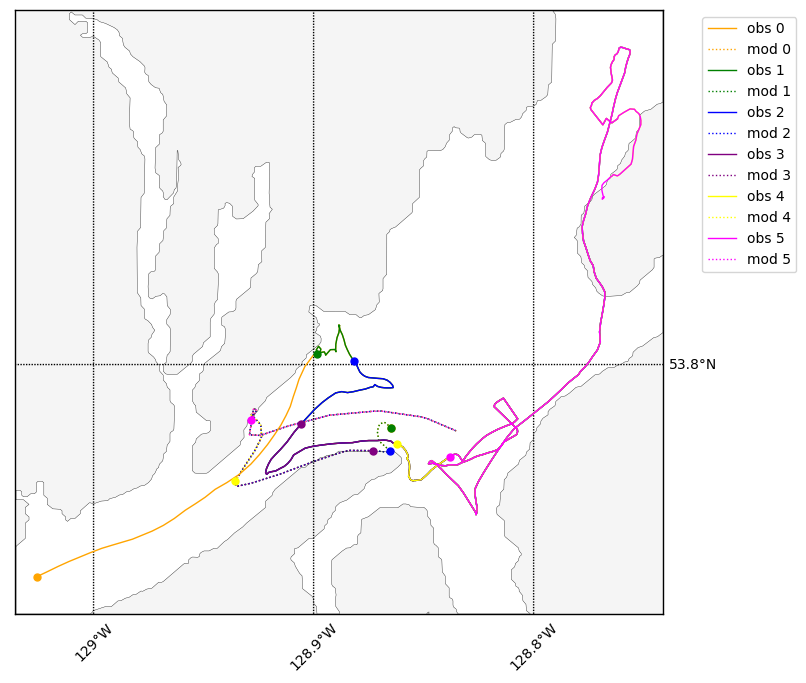

C:\Users\Holdenje\AppData\Local\conda\conda\envs\opendrift_update\lib\site-packages\ipykernel_launcher.py:51: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
C:\Users\Holdenje\AppData\Local\conda\conda\envs\opendrift_update\lib\site-packages\ipykernel_launcher.py:55: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.



modelrun:  0
obslat:  53.9103 53.68228
obslon:  -128.67546 -128.85609

modelrun:  1
obslat:  53.9103 53.68228
obslon:  -128.67546 -128.85609

modelrun:  2
obslat:  53.9103 53.68228
obslon:  -128.70732 -128.85609

modelrun:  3
obslat:  53.9103 53.68228
obslon:  -128.72714 -128.85609

modelrun:  4
obslat:  53.8679 53.68228
obslon:  -128.74983 -128.85609

modelrun:  5
obslat:  53.8679 53.68228
obslon:  -128.74983 -128.85609


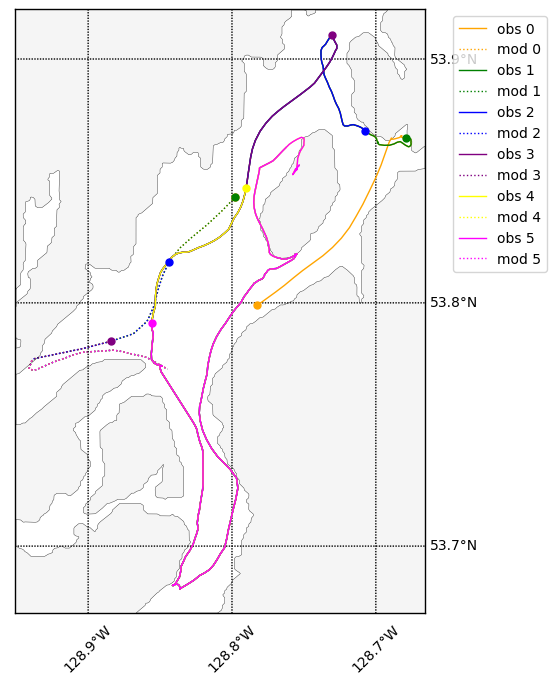

C:\Users\Holdenje\AppData\Local\conda\conda\envs\opendrift_update\lib\site-packages\ipykernel_launcher.py:51: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
C:\Users\Holdenje\AppData\Local\conda\conda\envs\opendrift_update\lib\site-packages\ipykernel_launcher.py:55: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.



modelrun:  0
obslat:  53.59025 53.53927
obslon:  -128.80898 -129.01749

modelrun:  1
obslat:  53.59025 53.53927
obslon:  -128.80898 -128.95078

modelrun:  2
obslat:  53.59025 53.53052
obslon:  -128.80898 -129.01225

modelrun:  3
obslat:  53.59025 53.52942
obslon:  -128.83293 -129.01225

modelrun:  4
obslat:  53.57891 53.51369
obslon:  -128.84712 -129.05725

modelrun:  5
obslat:  53.57891 53.51049
obslon:  -128.84712 -129.05797


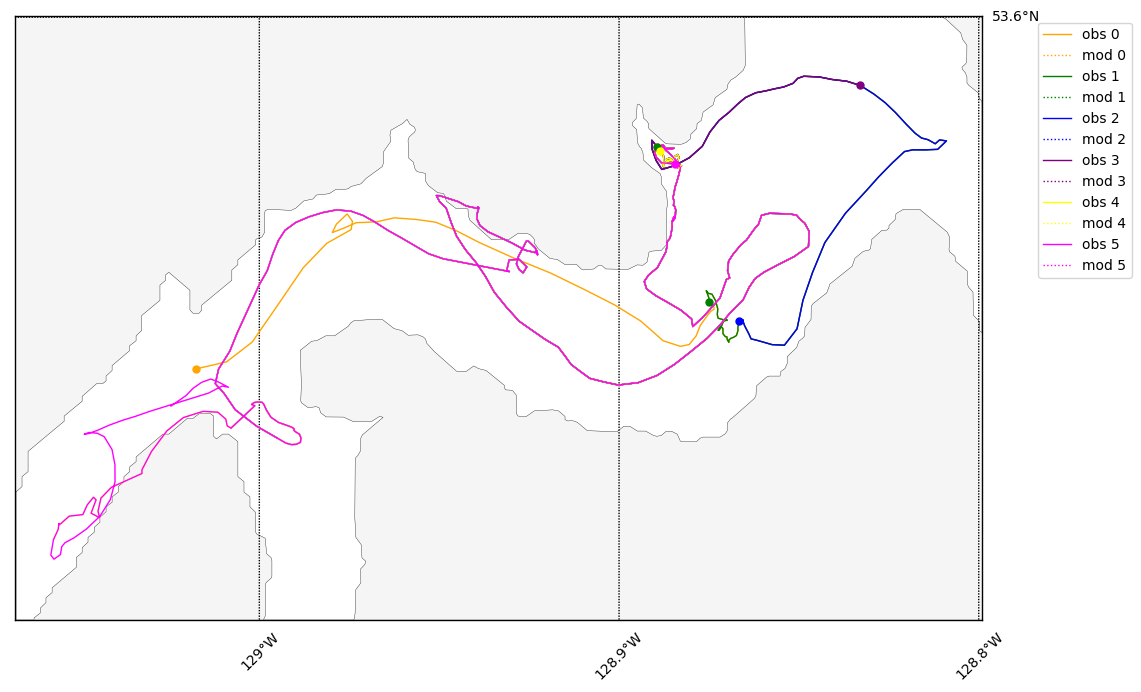

In [11]:
datadir="C:/Users/Holdenje/DRIFT/projects/mldp_implementation/sample_output/"

mldpfilelist = []
for file in glob.glob(os.path.join(datadir,"sct*.nc")):
    mldpfilelist.append(file)

odfilelist = []
for file in glob.glob(os.path.join(datadir,"P1D*.nc")):
    odfilelist.append(file)

for mfile in mldpfilelist:
    sname = os.path.basename(mfile).split('.')[0]
    saname = 'mldp_' + sname + '.png'
    mldpdfs = read_aggregated_output(mfile)
    plot_single_aggregated_file(mldpdfs, bbox=None, savedir=datadir, savename=saname, pcolors=None, useid=None)
    
#for ofile in odfilelist:
#    sname = os.path.basename(ofile).split('.')[0]
#    saname = 'od_' + sname + '.png'
#    print(datadir, saname)
#    oddfs = read_aggregated_output(ofile)
#    plot_single_aggregated_file(oddfs, bbox=None, savedir=datadir, savename=saname, pcolors=None, useid=None)

In [12]:
datadir="C:/Users/Holdenje/DRIFT/projects/mldp_implementation/sample_output/"

mldpfilelist = []
for file in glob.glob(os.path.join(datadir,"sct*.nc")):
    mldpfilelist.append(file)

odfilelist = []
for file in glob.glob(os.path.join(datadir,"P1D*.nc")):
    odfilelist.append(file)

for mfile in mldpfilelist:
    sname = os.path.basename(mfile).split('.')[0]
    saname = 'mldp_' + sname + '.png'
    mldpdfs = read_aggregated_output(mfile)
    examine_data(mldpdfs)


modelrun:  0
obslat:  53.81062 53.74303
modlat:  53.78802678845722 53.767257753965005
obslon:  -128.80725 -129.02576
modlon:  -128.86378326417667 -128.93574523925

modelrun:  1
obslat:  53.83517 53.75969
modlat:  53.78802678845722 53.767257753965005
obslon:  -128.76767 -128.9218
modlon:  -128.8351745605 -128.93574523925

modelrun:  2
obslat:  53.8851 53.75969
modlat:  53.78802678845722 53.767257753965005
obslon:  -128.7561 -128.9218
modlon:  -128.8351745605 -128.93574523925

modelrun:  3
obslat:  53.8851 53.75969
modlat:  53.78802678845722 53.767257753965005
obslon:  -128.7561 -128.9218
modlon:  -128.8351745605 -128.93574523925

modelrun:  4
obslat:  53.8851 53.75969
modlat:  53.78802678845722 53.768682479841665
obslon:  -128.75125 -128.86188
modlon:  -128.8351745605 -128.93550999958333

modelrun:  5
obslat:  53.8851 53.75969
modlat:  53.78802678845722 53.78098144530833
obslon:  -128.75125 -128.84778
modlon:  -128.8351745605 -128.9291381836

modelrun:  0
obslat:  53.9103 53.68228
modl

C:\Users\Holdenje\AppData\Local\conda\conda\envs\opendrift_update\lib\site-packages\ipykernel_launcher.py:153: RuntimeWarning: All-NaN axis encountered
C:\Users\Holdenje\AppData\Local\conda\conda\envs\opendrift_update\lib\site-packages\ipykernel_launcher.py:155: RuntimeWarning: All-NaN axis encountered
